In [1]:
import os
os.environ["PATH"] = "/usr/local/cuda-11.8/bin:{}".format(os.environ["PATH"])
os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda-11.8/lib64"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import sys
sys.path.append("/data1/yang_liu/python_workspace/GSPL")

import cv2
import torch
import numpy as np
import random
from torch import nn

from matplotlib import pyplot as plt
from internal.utils.ssim import ssim
from internal.utils.gaussian_model_loader import GaussianModelLoader
from internal.dataparsers.colmap_dataparser import ColmapParams, ColmapDataParser
from internal.dataparsers.colmap_block_dataparser import ColmapBlockParams, ColmapBlockDataParser
from internal.dataparsers.estimated_depth_colmap_block_dataparser import EstimatedDepthColmapBlockParams, EstimatedDepthColmapDataParser
from internal.renderers.vanilla_renderer import VanillaRenderer
from internal.renderers.vanilla_trim_renderer import VanillaTrimRenderer
from internal.renderers.sep_depth_trim_2dgs_renderer import SepDepthTrim2DGSRenderer
from internal.utils.sh_utils import eval_gaussian_model_sh
from internal.utils.graphics_utils import fetch_ply
from internal.utils.general_utils import inverse_sigmoid
from internal.models.gaussian_model import GaussianModel
from internal.utils.sh_utils import SH2RGB

torch.set_grad_enabled(False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def build_rotation(r):
    norm = torch.sqrt(r[:,0]*r[:,0] + r[:,1]*r[:,1] + r[:,2]*r[:,2] + r[:,3]*r[:,3])

    q = r / norm[:, None]

    R = torch.zeros((q.size(0), 3, 3), device='cuda')

    r = q[:, 0]
    x = q[:, 1]
    y = q[:, 2]
    z = q[:, 3]

    R[:, 0, 0] = 1 - 2 * (y*y + z*z)
    R[:, 0, 1] = 2 * (x*y - r*z)
    R[:, 0, 2] = 2 * (x*z + r*y)
    R[:, 1, 0] = 2 * (x*y + r*z)
    R[:, 1, 1] = 1 - 2 * (x*x + z*z)
    R[:, 1, 2] = 2 * (y*z - r*x)
    R[:, 2, 0] = 2 * (x*z - r*y)
    R[:, 2, 1] = 2 * (y*z + r*x)
    R[:, 2, 2] = 1 - 2 * (x*x + y*y)
    return R

def build_scaling_rotation(s, r):
    L = torch.zeros((s.shape[0], 3, 3), dtype=torch.float, device="cuda")
    R = build_rotation(r)

    L[:,0,0] = s[:,0]
    L[:,1,1] = s[:,1]
    L[:,2,2] = s[:,2]

    L = R @ L
    return L

def getProjectionMatrix(znear, zfar, fovX, fovY):
    import math
    tanHalfFovY = math.tan((fovY / 2))
    tanHalfFovX = math.tan((fovX / 2))

    top = tanHalfFovY * znear
    bottom = -top
    right = tanHalfFovX * znear
    left = -right

    P = torch.zeros(4, 4)

    z_sign = 1.0

    P[0, 0] = 2.0 * znear / (right - left)
    P[1, 1] = 2.0 * znear / (top - bottom)
    P[0, 2] = (right + left) / (right - left)
    P[1, 2] = (top + bottom) / (top - bottom)
    P[3, 2] = z_sign
    P[2, 2] = z_sign * zfar / (zfar - znear)
    P[2, 3] = -(zfar * znear) / (zfar - znear)
    return P

def focal2fov(focal, pixels):
    import math
    return 2*math.atan(pixels/(2*focal))

def homogeneous(points):
    """
    homogeneous points
    :param points: [..., 3]
    """
    return torch.cat([points, torch.ones_like(points[..., :1])], dim=-1)

def homogeneous_vec(vec):
    """
    homogeneous points
    :param points: [..., 3]
    """
    return torch.cat([vec, torch.zeros_like(vec[..., :1])], dim=-1)

In [3]:
def alpha_blending(alpha, colors):
  T = torch.cat([torch.ones_like(alpha[-1:]), (1-alpha).cumprod(dim=0)[:-1]], dim=0)
  image = (T * alpha * (alpha >= 1.0 / 255.0) * colors).sum(dim=0).reshape(-1, colors.shape[-1])
  alphamap = (T * alpha * (alpha >= 1.0 / 255.0)).sum(dim=0).reshape(-1, 1)

  # only for debugging
  # a = torch.cumsum((T * alpha * colors)[alpha[:, 0, 0] > 0], dim=0)
  # a_colors = colors[alpha[:, 0, 0] > 0]
  # a_weight = (T * alpha)[alpha[:, 0, 0] > 0]

  return image, alphamap


def alpha_blending_with_gaussians(dist2, colors, opacities, depth_acc, H=None, W=None):
    colors = colors.reshape(-1,1,colors.shape[-1])
    depth_acc = depth_acc.T[..., None]
    depth_acc = depth_acc.repeat(1,1,1)

    # evaluate gaussians
    # just for visualization, the actual cut off can be 3 sigma!
    cutoff = 9.0  # 1e0 for surface visualization
    dist2 = dist2.T
    gaussians = torch.exp(-0.5*dist2) * (dist2 < cutoff)
    gaussians = gaussians[..., None]
    alpha = (opacities.unsqueeze(1) * gaussians * (depth_acc > 0.0)).clamp(0, 0.99)

    # accumulate gaussians
    image, _ = alpha_blending(alpha, colors)
    depthmap, alphamap = alpha_blending(alpha, depth_acc)
    depthmap = depthmap / alphamap
    depthmap = torch.nan_to_num(depthmap, 0, 0)

    if H is not None and W is not None:
      return image.reshape(H,W,-1), depthmap.reshape(H,W,-1), alphamap.reshape(H,W,-1)
    else:
      return image, depthmap, alphamap

In [4]:
# Surface splatting (2D Gaussian Splatting)
def setup(means3D, scales, quats, opacities, colors, viewmat, projmat):
    rotations = build_scaling_rotation(scales, quats).permute(0,2,1)

    # 1. Viewing transform
    # Eq.4 and Eq.5
    p_view = (means3D @ viewmat[:3,:3]) + viewmat[-1:,:3]
    uv_view = (rotations @ viewmat[:3,:3])
    M = torch.cat([homogeneous_vec(uv_view[:,:2,:]), homogeneous(p_view.unsqueeze(1))], dim=1)

    T = M @ projmat # T stands for (WH)^T in Eq.9
    # 2. Compute AABB
    # Homogneous plane is very useful for both ray-splat intersection and bounding box computation
    # we know how to compute u,v given x,y homogeneous plane already; computing AABB is done by a reverse process.
    # i.e compute the x, y s.t. \|hu^4\| = 1 and \|h_v^4\|=1 (distance of gaussian center to plane in the uv space)
    temp_point = torch.tensor([[1.,1., -1.]]).cuda()
    distance = (temp_point * (T[..., 3] * T[..., 3])).sum(dim=-1, keepdims=True)
    f = (1 / distance) * temp_point
    point_image = torch.cat(
        [(f * T[..., 0] * T[...,3]).sum(dim=-1, keepdims=True),
        (f * T[..., 1] * T[...,3]).sum(dim=-1, keepdims=True),
        (f * T[..., 2] * T[...,3]).sum(dim=-1, keepdims=True)], dim=-1)

    half_extend = point_image * point_image - torch.cat(
        [(f * T[..., 0] * T[...,0]).sum(dim=-1, keepdims=True),
        (f * T[..., 1] * T[...,1]).sum(dim=-1, keepdims=True),
        (f * T[..., 2] * T[...,2]).sum(dim=-1, keepdims=True)], dim=-1)

    radii = half_extend.clamp(min=1e-4).sqrt() * 3 # three sigma
    center = point_image

    # 3. Perform Sorting
    depth = p_view[..., 2] # depth is used only for sorting
    index = depth.sort()[1]
    T = T[index]
    colors = colors[index]
    center = center[index]
    depth = depth[index]
    radii = radii[index]
    opacities = opacities[index]
    return T, colors, opacities, center, depth, radii

def surface_splatting(means3D, scales, quats, colors, opacities, viewpoint_camera, batch_size=50):
    # Rasterization setup
    projmat = torch.zeros(4,4).cuda()
    projmat[0, 0] = viewpoint_camera.fx
    projmat[1, 1] = viewpoint_camera.fy
    projmat[0, 2] = viewpoint_camera.cx
    projmat[1, 2] = viewpoint_camera.cy
    projmat[-1,-2] = 1.0
    projmat = projmat.T
    T, colors, opacities, center, depth, radii = setup(means3D, scales, quats, opacities, colors, viewpoint_camera.world_to_camera, projmat)

    # plt.figure(figsize=(10,10))
    # plt.scatter(center[::10, 0].cpu().numpy(), center[::10, 1].cpu().numpy(), c=colors[::10].clamp(0, 1).cpu().numpy(), s=1)
    # plt.xlim(0, int(viewpoint_camera.width))
    # plt.ylim(int(viewpoint_camera.height), 0)
    # plt.show()

    # Rasterization
    # 1. Generate pixels
    W, H = int(viewpoint_camera.width), int(viewpoint_camera.height)

    pix = torch.stack(torch.meshgrid(torch.arange(W),
        torch.arange(H), indexing='xy'), dim=-1).to('cuda')

    x = pix.reshape(-1,1,2)[..., :1]
    y = pix.reshape(-1,1,2)[..., 1:]

    out_image = torch.zeros((H, W, 3), device='cuda')
    out_depthmap = torch.zeros((H, W, 1), device='cuda')
    out_alphamap = torch.zeros((H, W, 1), device='cuda')

    center_left = center[:, :2] - radii[:, :2]
    center_right = center[:, :2] + radii[:, :2]

    for i in range(0, W - batch_size + 1, batch_size):
        for j in range(0, H - batch_size + 1, batch_size):

            # 2. Compute ray splat intersection # Eq.9 and Eq.10

            # if not (i == 480 and j == 739):
            #     continue

            # if not (i == 488 and j == 739):
            #     continue
            
            pix_patch = pix[j:j+batch_size, i:i+batch_size]
            x_patch = pix_patch.reshape(-1,1,2)[..., :1]
            y_patch = pix_patch.reshape(-1,1,2)[..., 1:]

            x_min, x_max = x_patch.min(), x_patch.max()
            y_min, y_max = y_patch.min(), y_patch.max()

            inv_mask = (center_left[:, 0] > x_max) | (center_right[:, 0] < x_min) | (center_left[:, 1] > y_max) | (center_right[:, 1] < y_min) | (depth < 0.2)
            
            k = -T[None, ~inv_mask, :, 0] + x_patch * T[None, ~inv_mask, :, 3]
            l = -T[None, ~inv_mask, :, 1] + y_patch * T[None, ~inv_mask, :, 3]
            points = torch.cross(k, l, dim=-1)
            s = points[..., :2] / points[..., -1:]

            # 3. add low pass filter # Eq. 11
            # when a point (2D Gaussian) viewed from a far distance or from a slended angle
            # the 2D Gaussian will falls between pixels and no fragment is used to rasterize the Gaussian
            # so we should add a low pass filter to handle such aliasing.
            dist3d = (s * s).sum(dim=-1)
            filtersze = np.sqrt(2) / 2
            dist2d = (1/filtersze)**2 * (torch.cat([x_patch,y_patch], dim=-1) - center[None,~inv_mask,:2]).norm(dim=-1)**2
            # min of dist2 is equal to max of Gaussian exp(-0.5 * dist2)
            dist2 = torch.min(dist3d, dist2d)
            # dist2 = dist3d
            # s[dist3d > dist2d] = 0
            depth_acc = (homogeneous(s) * T[None, ~inv_mask, :, -1]).sum(dim=-1)
            # depth_acc[dist3d > dist2d] = T[None, ~inv_mask, -1, -1]

            # 4. accumulate 2D gaussians through alpha blending # Eq.12
            image, depthmap, alphamap = alpha_blending_with_gaussians(dist2, colors[~inv_mask], opacities[~inv_mask], depth_acc)

            out_image[y_patch[:, 0, 0], x_patch[:, 0, 0]] = image
            out_depthmap[y_patch[:, 0, 0], x_patch[:, 0, 0]] = depthmap
            out_alphamap[y_patch[:, 0, 0], x_patch[:, 0, 0]] = alphamap

    return out_image, out_depthmap, out_alphamap, center, radii

In [5]:
# load dataset
dataparser_outputs = EstimatedDepthColmapDataParser(
    os.path.expanduser("../data/matrix_city/street/train/block_A"),
    os.path.abspath(""),
    global_rank=0,
    params=EstimatedDepthColmapBlockParams(
        # split_mode="experiment",
        # eval_image_select_mode="ratio",
        # eval_ratio=0.1,
        # down_sample_factor=3.4175,
    ),
).get_outputs()
print("Train camera count: {}".format(len(dataparser_outputs.train_set.cameras)))

appearance group by camera id
loading colmap 3D points
[colmap dataparser] train set images: 4075, val set images: 510, loaded mask: 0
[WARNING depth scale of 0243.png out of bound]
[WARNING depth scale of 0281.png out of bound]
[WARNING depth scale of 0284.png out of bound]
[WARNING depth scale of 0285.png out of bound]
[WARNING depth scale of 0311.png out of bound]
[WARNING depth scale of 0310.png out of bound]
[WARNING depth scale of 0312.png out of bound]
[WARNING depth scale of 0313.png out of bound]
[WARNING depth scale of 0315.png out of bound]
[WARNING depth scale of 0332.png out of bound]
[WARNING depth scale of 0340.png out of bound]
[WARNING depth scale of 0344.png out of bound]
[WARNING depth scale of 0354.png out of bound]
[WARNING depth scale of 0356.png out of bound]
[WARNING depth scale of 0357.png out of bound]
[WARNING depth scale of 0362.png out of bound]
[WARNING depth scale of 0366.png out of bound]
[WARNING depth scale of 0384.png out of bound]
[WARNING depth scal

In [6]:
# load from scratch
# file_dir = "../data/matrix_city/street/train/block_A/sparse/0/points3D.ply"
# model = GaussianModel(sh_degree=3)
# model.create_from_pcd(fetch_ply(file_dir), device='cuda')
# # model._scaling = nn.Parameter(torch.log(torch.exp(model._scaling) / 100.0))
# model._opacity = nn.Parameter(inverse_sigmoid(torch.ones((model.get_xyz.shape[0], 1), dtype=torch.float, device="cuda")))
# renderer = VanillaRenderer()
# renderer.setup(stage="val")
# renderer = renderer.to("cuda")


# load from checkpoint
load_from = "../outputs/citygs2d_mc_street_coarse_lnorm4_wo_vast_6w"
model, renderer = GaussianModelLoader.search_and_load(load_from, sh_degree=3, device="cuda")
if isinstance(renderer, VanillaTrimRenderer):
    model._scaling = torch.cat((torch.ones_like(model._scaling[:, :1]) * 1e-8, model._scaling[:, [-2, -1]]), dim=1)
    flatten_gs = True
else:
    flatten_gs = False
print("Gaussian count: {}".format(model.get_xyz.shape[0]))

Gaussian count: 1815187


## 1. Just Rendering

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.040978923..1.0525357].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0003898341..1.0662016].


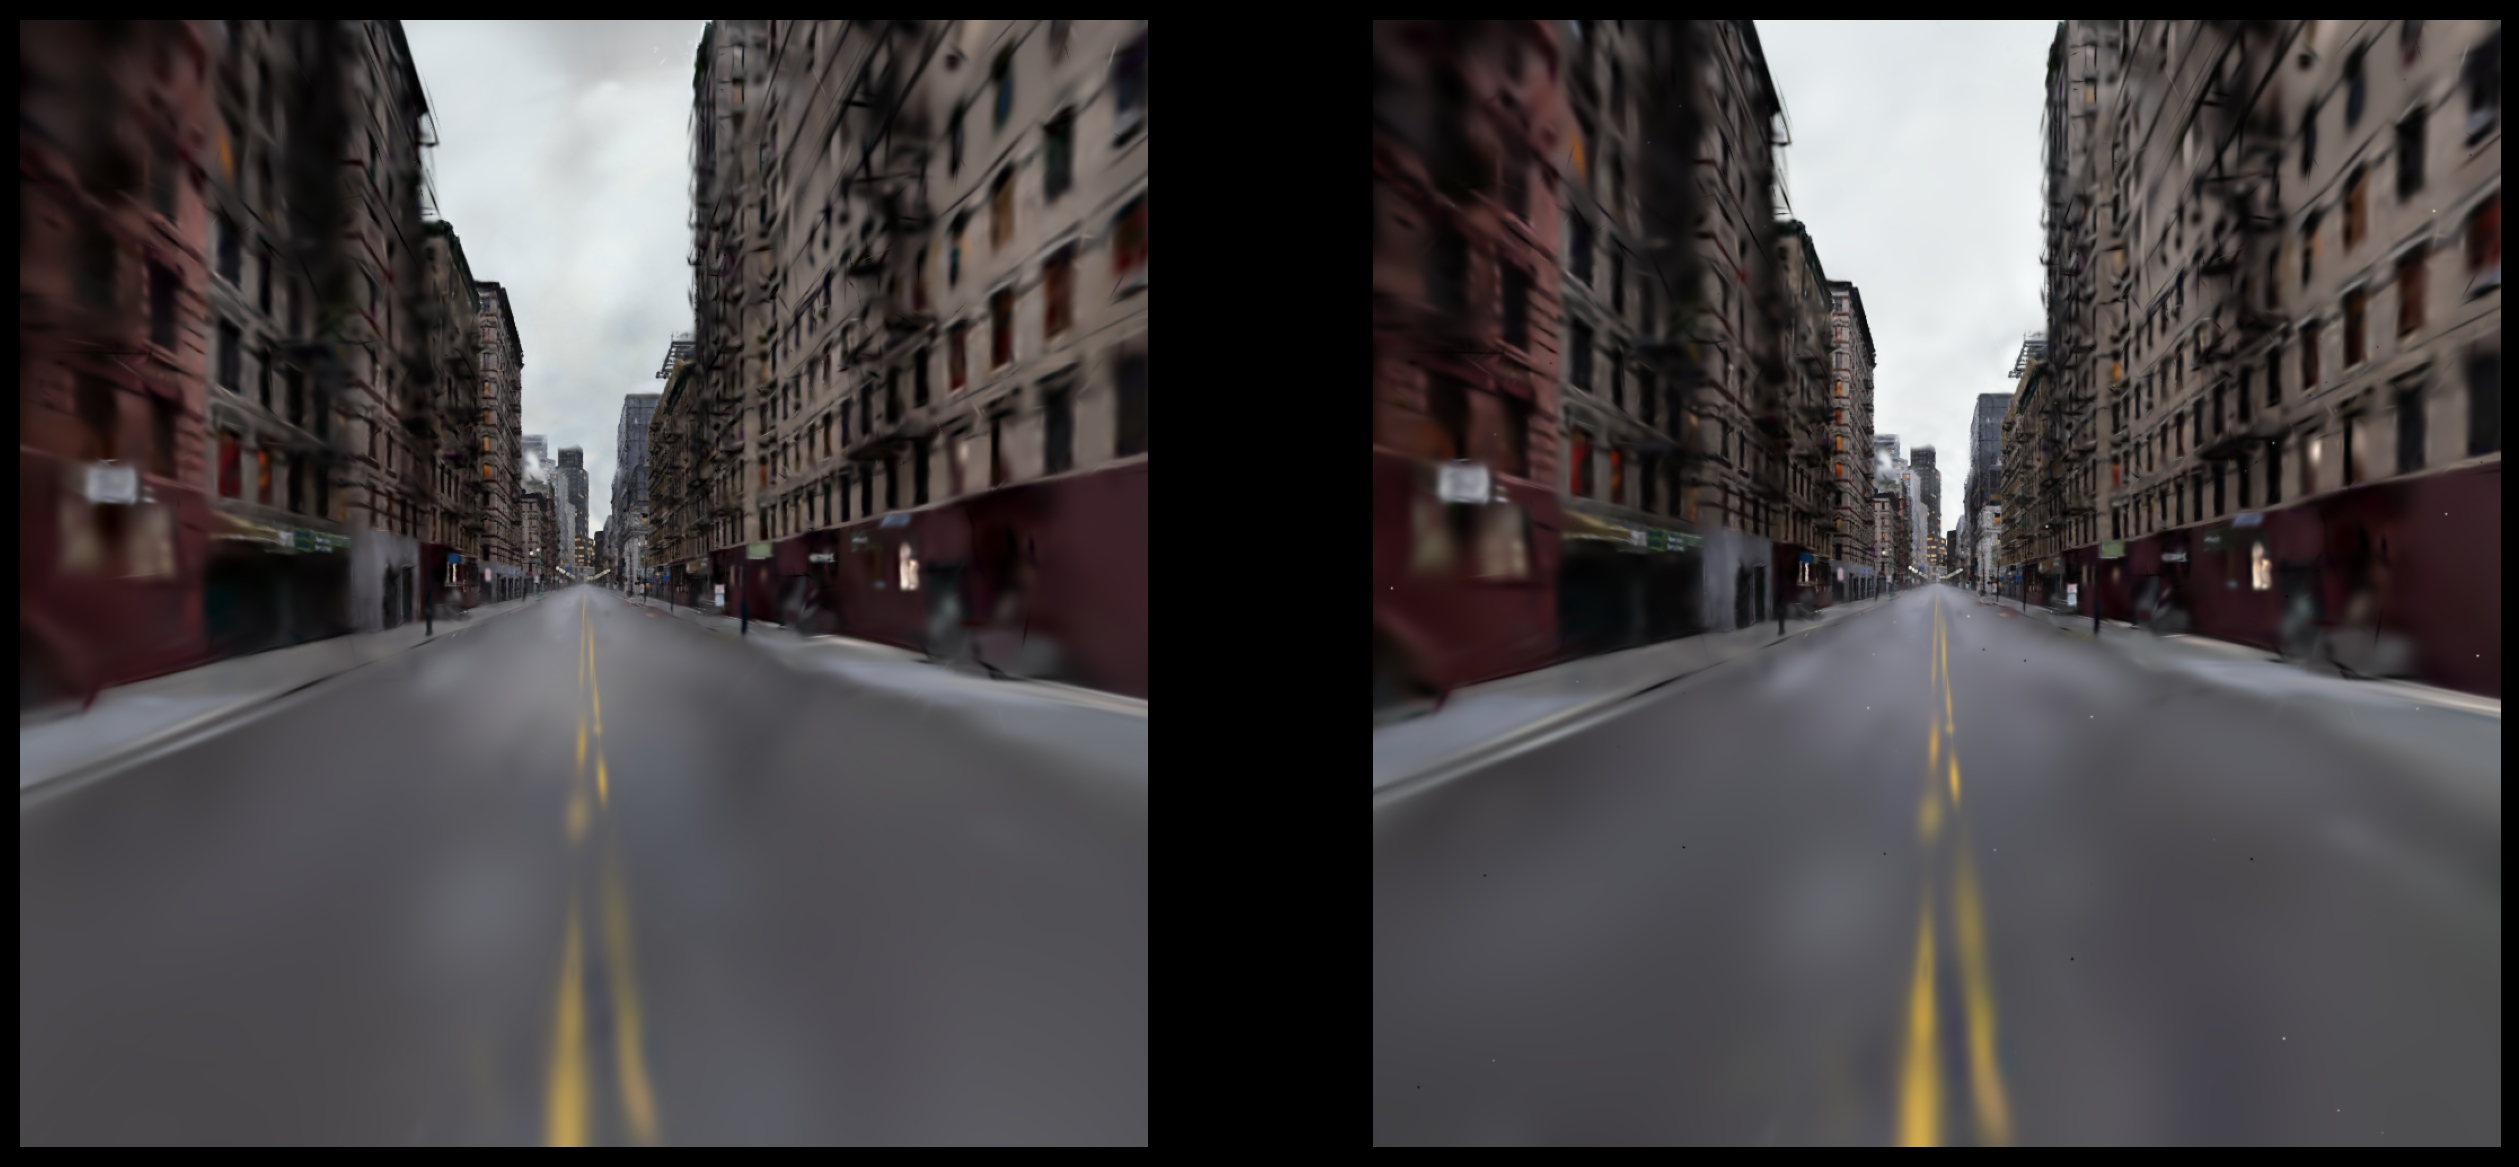

In [7]:
with torch.no_grad():
    idx = random.randint(0, len(dataparser_outputs.train_set.cameras) - 1)
    idx = 90
    camera = dataparser_outputs.train_set.cameras[idx].to_device("cuda")
    results = renderer(camera, model, bg_color=torch.tensor([0, 0, 0], dtype=torch.float, device="cuda"))

    means3D = model.get_xyz
    scales = model.get_scaling
    quats = model.get_rotation
    colors = SH2RGB(model.get_features[:, 0, :])
    opacities = model.get_opacity

    image, depthmap, alphamap, center, radii = surface_splatting(
        means3D, scales, quats, colors, opacities, camera
    )

    # image = results['render'].clone().permute(1,2,0)
    # image[image < 1] = 0

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(image.cpu().numpy())
    ax[0].axis("off")
    ax[1].imshow(results['render'].permute(1,2,0).cpu().numpy())
    ax[1].axis("off")

    # img_cv = (image.clamp(0,1).cpu().numpy() * 255).astype(np.uint8)
    # cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB, img_cv)
    # cv2.imwrite("image.png", img_cv)


In [8]:
print(image[739, 488] * 255)
print(f"maximum rgb value: {torch.max(results['render'])}")
print(f"minimum rgb value: {torch.min(results['render'])}")

tensor([92.1052, 90.9152, 94.1256], device='cuda:0')
maximum rgb value: 1.0662015676498413
minimum rgb value: 0.00038983410922810435
